Step 1: Prior to uploading the data into pyspark, load the beerreviews.csv dataset into S3 bucket.  The csv can be downloaded from: https://www.kaggle.com/rdoume/beerreviews#__sid=js0

In [ ]:
# Define a manual schema
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType,DoubleType, DateType

manual_schema = StructType([
    # brewry id: unique identifier of brewery
    StructField("brewery_id", IntegerType(), True),
    # name of each brewery
    StructField("brewery_name", StringType(), True),
    # time of review in integer format
    StructField("review_time", IntegerType(), True),
    # overall review of each beer on scale of 1-5
    StructField("review_overall", DoubleType(), True),
    # review of beer aroma on a scale of 1-5
    StructField("review_aroma", DoubleType(), True),
    # review of beer appearance on a scale of 1-5
    StructField("review_appearance", DoubleType(), True),
    # profile name of reviewer - unique string
    StructField("review_profilename", StringType(), True),
    # beer style (ex. IPA, lager, etc.)
    StructField("beer_style", StringType(), True),
    # review of beer palate on scale of 1-5
    StructField("review_palate", DoubleType(), True),
    # review of beer taste on scale of 1-5
    StructField("review_taste", DoubleType(), True),
    # beer name - string
    StructField("beer_name", StringType(), True),
    # ABV (alcohol by volume) of beer
    StructField("beer_abv", DoubleType(), True),
    # beer id - unique identifier of beer being reviewed
    StructField("beer_beerid", IntegerType(), True)])

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1605973483428_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# read in the data from S3 bucket
# replace 's3://dehli-bigdata/beerreviews/beer_reviews.csv' with your own S3 bucket link
beer = spark.read.format("csv").schema(manual_schema).option("header", "true").csv('s3://dehli-bigdata/beerreviews/beer_reviews.csv')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# check that the schema was successful
beer.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- brewery_id: integer (nullable = true)
 |-- brewery_name: string (nullable = true)
 |-- review_time: integer (nullable = true)
 |-- review_overall: double (nullable = true)
 |-- review_aroma: double (nullable = true)
 |-- review_appearance: double (nullable = true)
 |-- review_profilename: string (nullable = true)
 |-- beer_style: string (nullable = true)
 |-- review_palate: double (nullable = true)
 |-- review_taste: double (nullable = true)
 |-- beer_name: string (nullable = true)
 |-- beer_abv: double (nullable = true)
 |-- beer_beerid: integer (nullable = true)

In [ ]:
# check out the first few rows
beer.take(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(brewery_id=10325, brewery_name='Vecchio Birraio', review_time=1234817823, review_overall=1.5, review_aroma=2.0, review_appearance=2.5, review_profilename='stcules', beer_style='Hefeweizen', review_palate=1.5, review_taste=1.5, beer_name='Sausa Weizen', beer_abv=5.0, beer_beerid=47986), Row(brewery_id=10325, brewery_name='Vecchio Birraio', review_time=1235915097, review_overall=3.0, review_aroma=2.5, review_appearance=3.0, review_profilename='stcules', beer_style='English Strong Ale', review_palate=3.0, review_taste=3.0, beer_name='Red Moon', beer_abv=6.2, beer_beerid=48213), Row(brewery_id=10325, brewery_name='Vecchio Birraio', review_time=1235916604, review_overall=3.0, review_aroma=2.5, review_appearance=3.0, review_profilename='stcules', beer_style='Foreign / Export Stout', review_palate=3.0, review_taste=3.0, beer_name='Black Horse Black Beer', beer_abv=6.5, beer_beerid=48215), Row(brewery_id=10325, brewery_name='Vecchio Birraio', review_time=1234725145, review_overall=3.0, re

In [ ]:
# find number of partitions
beer.rdd.getNumPartitions()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2

In [ ]:
# This dataset is small enough that we don't need to increase the number of partitions.
# If a company was continuing to grow this data, they could choose to repartition in the future.

In [ ]:
# get summary statistics for some of the numerical variables
dscr_cols = ['review_aroma', 'review_appearance', 'review_overall', 'review_palate', 'review_taste']
beer.select(dscr_cols).describe().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|      review_aroma| review_appearance|    review_overall|     review_palate|      review_taste|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|           1586266|           1586266|           1586266|           1586266|           1586266|
|   mean| 3.735685565976955|  3.84167125816225|3.8156280220341356|3.7437532544982997|3.7929209224682365|
| stddev|0.6975674474672164|0.6160649705043265|0.7205948113732451| 0.682175283752888|0.7319121675111695|
|    min|               1.0|               0.0|               0.0|               1.0|               1.0|
|    max|               5.0|               5.0|               5.0|               5.0|               5.0|
+-------+------------------+------------------+------------------+------------------+------------------+

In [ ]:
# use Spark SQL to generate insights
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# read files into Spark SQL table
beer.registerTempTable("beer")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SQL Queries: Generating Insights

In [ ]:
# Which beers have the highest ratings in the dataset?
sqlContext.sql('SELECT beer_name, avg(review_overall) AS average_rating FROM beer GROUP BY beer_name ORDER BY average_rating DESC').limit(10).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+
|           beer_name|average_rating|
+--------------------+--------------+
|      Moon Beam Blue|           5.0|
|      Southern Belle|           5.0|
|              Auburn|           5.0|
|       Wexford Wheat|           5.0|
|Suke Quto Coffee IPA|           5.0|
+--------------------+--------------+

In [ ]:
# it's possible some of these beers only have one or two ratings
# let's filter by number of reviews > 1000 to avoid this problem
sqlContext.sql('SELECT beer_name, ROUND(avg(review_overall),2) AS average_rating, count(*) AS num_reviews FROM beer GROUP BY beer_name HAVING num_reviews > 1000 ORDER BY average_rating DESC').limit(10).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+-----------+
|           beer_name|average_rating|num_reviews|
+--------------------+--------------+-----------+
|Trappist Westvlet...|          4.62|       1272|
|     Pliny The Elder|          4.59|       2527|
|Weihenstephaner H...|          4.52|       1980|
|           The Abyss|          4.45|       1412|
|Sculpin India Pal...|          4.44|       1352|
|        Supplication|          4.43|       1053|
|Founders KBS (Ken...|           4.4|       1930|
|Tröegs Nugget Nectar|           4.4|       1954|
|         Gumballhead|           4.4|       1234|
|  Bell's Hopslam Ale|          4.38|       2443|
+--------------------+--------------+-----------+

In [ ]:
# Which breweries have the most reviews?
sqlContext.sql('SELECT brewery_name, count(*) AS num_reviews FROM beer GROUP BY brewery_name ORDER BY num_reviews DESC').limit(10).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------+
|        brewery_name|num_reviews|
+--------------------+-----------+
|Boston Beer Compa...|      39438|
|Dogfish Head Brewery|      33829|
|   Stone Brewing Co.|      33053|
|Sierra Nevada Bre...|      28746|
|Bell's Brewery, Inc.|      25189|
|          Rogue Ales|      24079|
|Founders Brewing ...|      20000|
|Victory Brewing C...|      19473|
|Lagunitas Brewing...|      16832|
|Avery Brewing Com...|      16105|
+--------------------+-----------+

In [ ]:
# Seeing that Boston Beer Company has the highest number of reviews, 
#let's find which beers they have in the dataset and their average reviews for each review category
# ordered by average overall review
sqlContext.sql("SELECT beer_name, ROUND(avg(review_overall),2) AS average_overall, ROUND(avg(review_aroma),2) AS average_aroma, ROUND(avg(review_appearance),2) AS average_appearance, ROUND(avg(review_taste),2) AS average_taste FROM beer WHERE brewery_name LIKE 'Boston Beer Company%' GROUP BY beer_name ORDER BY average_overall DESC").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------------+-------------+------------------+-------------+
|           beer_name|average_overall|average_aroma|average_appearance|average_taste|
+--------------------+---------------+-------------+------------------+-------------+
|Samuel Adams Mill...|           4.57|         4.57|              4.02|         4.57|
|Samuel Adams Riva...|            4.5|          3.5|               4.0|          4.0|
|      Holiday Kölsch|            4.5|          2.5|               4.0|          4.0|
|Samuel Adams Hell...|            4.5|         3.75|              3.75|          4.0|
|Samuel Adams Crea...|            4.5|          4.0|               4.5|          4.5|
|Samuel Adams New ...|            4.5|          4.0|               3.5|          4.5|
|              Koggen|            4.5|          3.0|               4.0|          5.0|
|  Samuel Adams Stout|           4.25|          3.5|              3.75|          4.5|
|Sam Adam's 11th A...|           4.25|          4.0|  

Visualizations

To be able to use Python libraries like Seaborn, type the following command into the shell:
sudo python3.7 -m pip install seaborn

In [ ]:
# import seaborn library for plotting
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# create pandas dataframe from Spark dataframe to ensure compatibility with seaborn
beer_df = beer.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
beer_df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   brewery_id             brewery_name  ...  beer_beerid  user_id
0       10325          Vecchio Birraio  ...        47986     72.0
1       10325          Vecchio Birraio  ...        48213     72.0
2       10325          Vecchio Birraio  ...        48215     72.0
3       10325          Vecchio Birraio  ...        47969     72.0
4        1075  Caldera Brewing Company  ...        64883     47.0

[5 rows x 14 columns]

In [ ]:
# create a plot for the distriibution of beer reviews overall
plt.clf()
plt.figure(figsize=(20,10))
plt.style.use('classic')
plt.hist(beer_df.review_overall, bins=10)
plt.title('Distribution of Overall Reviews')
plt.xlabel('Review')
plt.ylabel('Count')
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

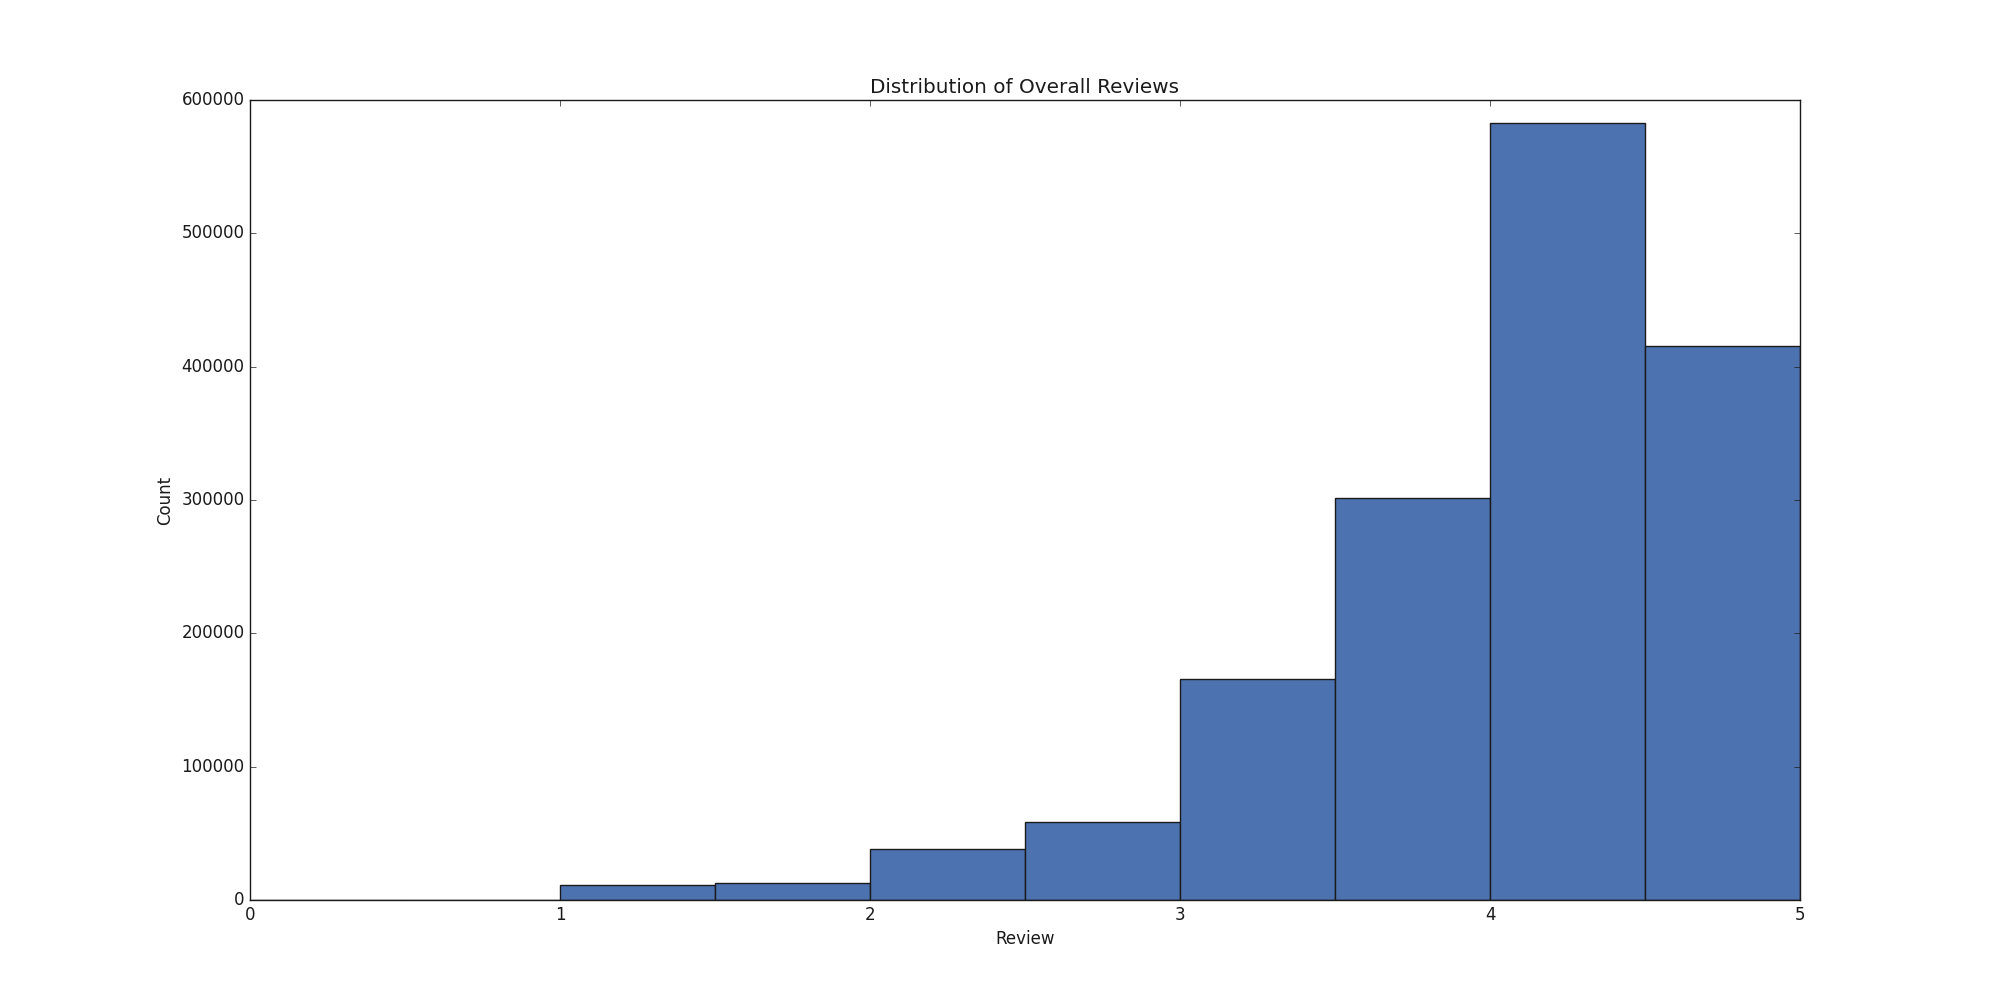

In [ ]:
%matplot plt

In [ ]:
# Create a plot for distribution of reviews for aroma
plt.clf()
plt.figure(figsize=(20,10))
plt.style.use('classic')
plt.hist(beer_df.review_aroma, bins=10)
plt.title('Distribution of Aroma Reviews')
plt.xlabel('Review')
plt.ylabel('Count')
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

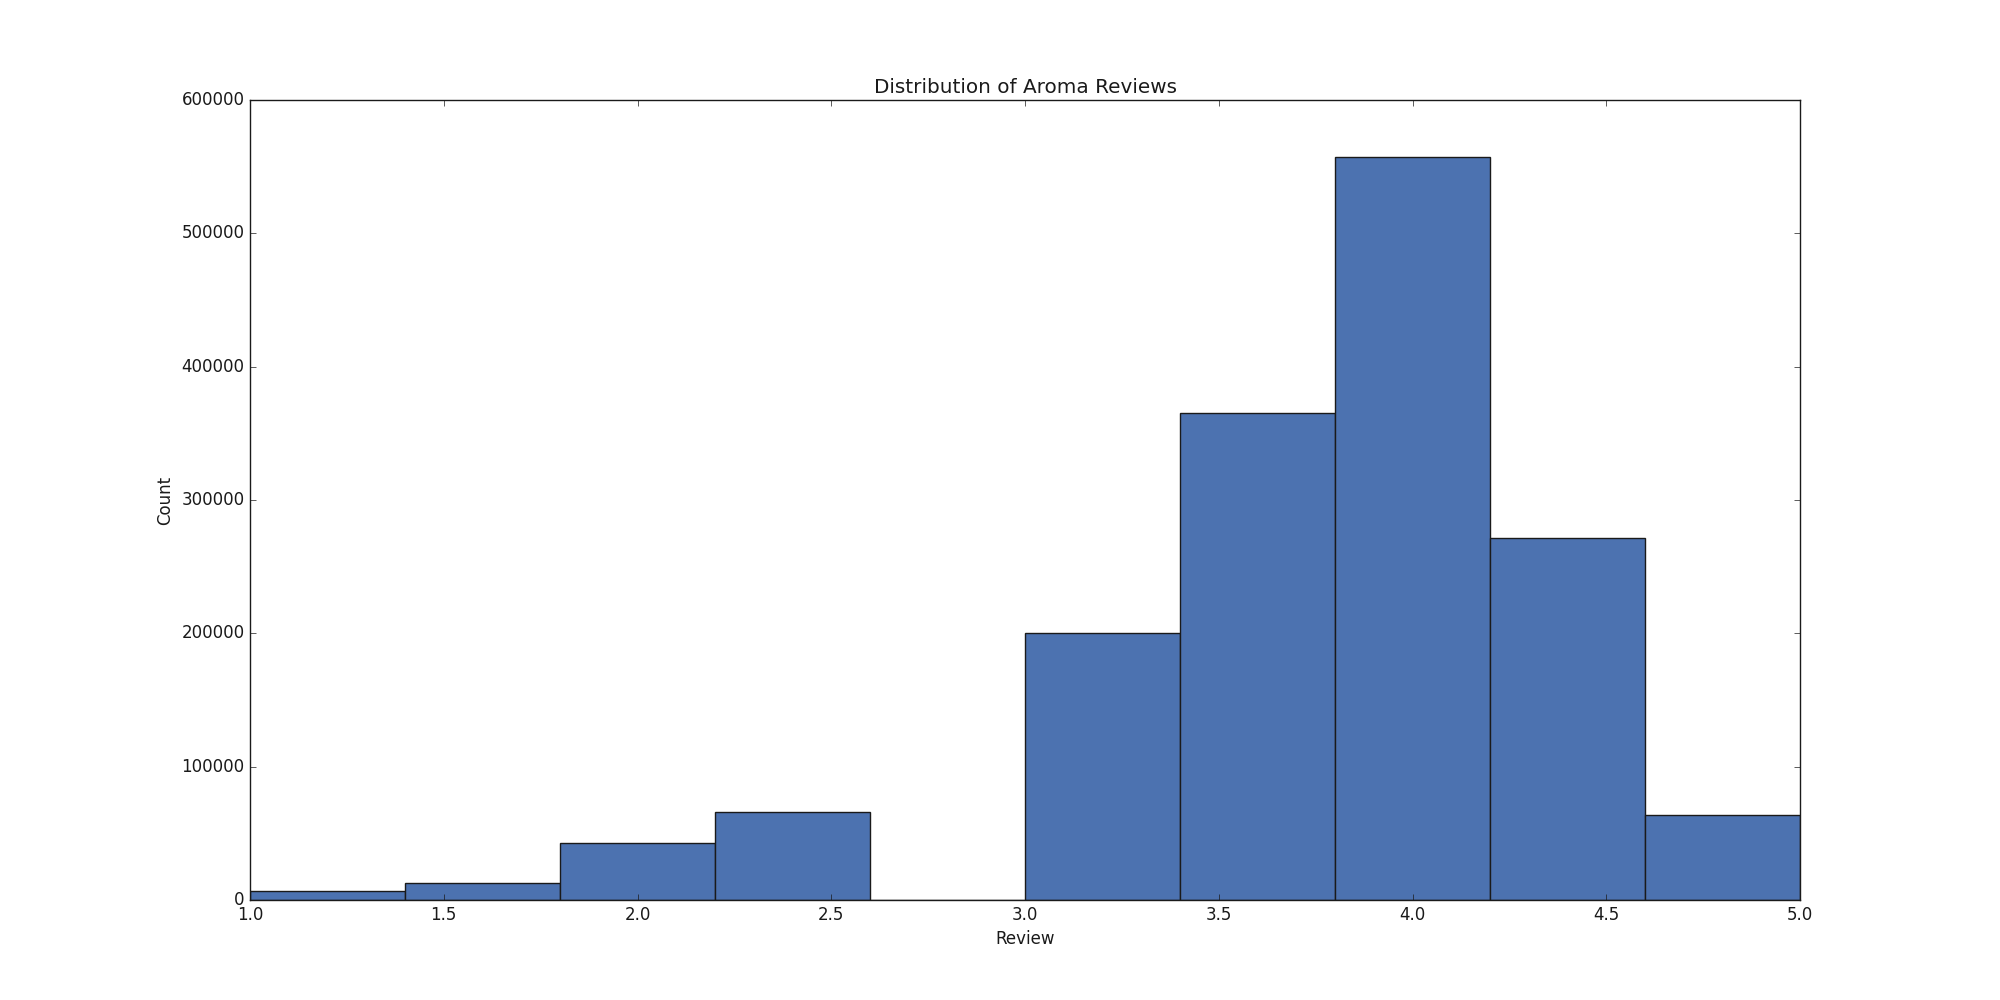

In [ ]:
%matplot plt

In [ ]:
# Create a plot for distribution of reviews for appearance
plt.clf()
plt.figure(figsize=(20,10))
plt.style.use('classic')
plt.hist(beer_df.review_appearance, bins=10)
plt.title('Distribution of Appearance Reviews')
plt.xlabel('Review')
plt.ylabel('Count')
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

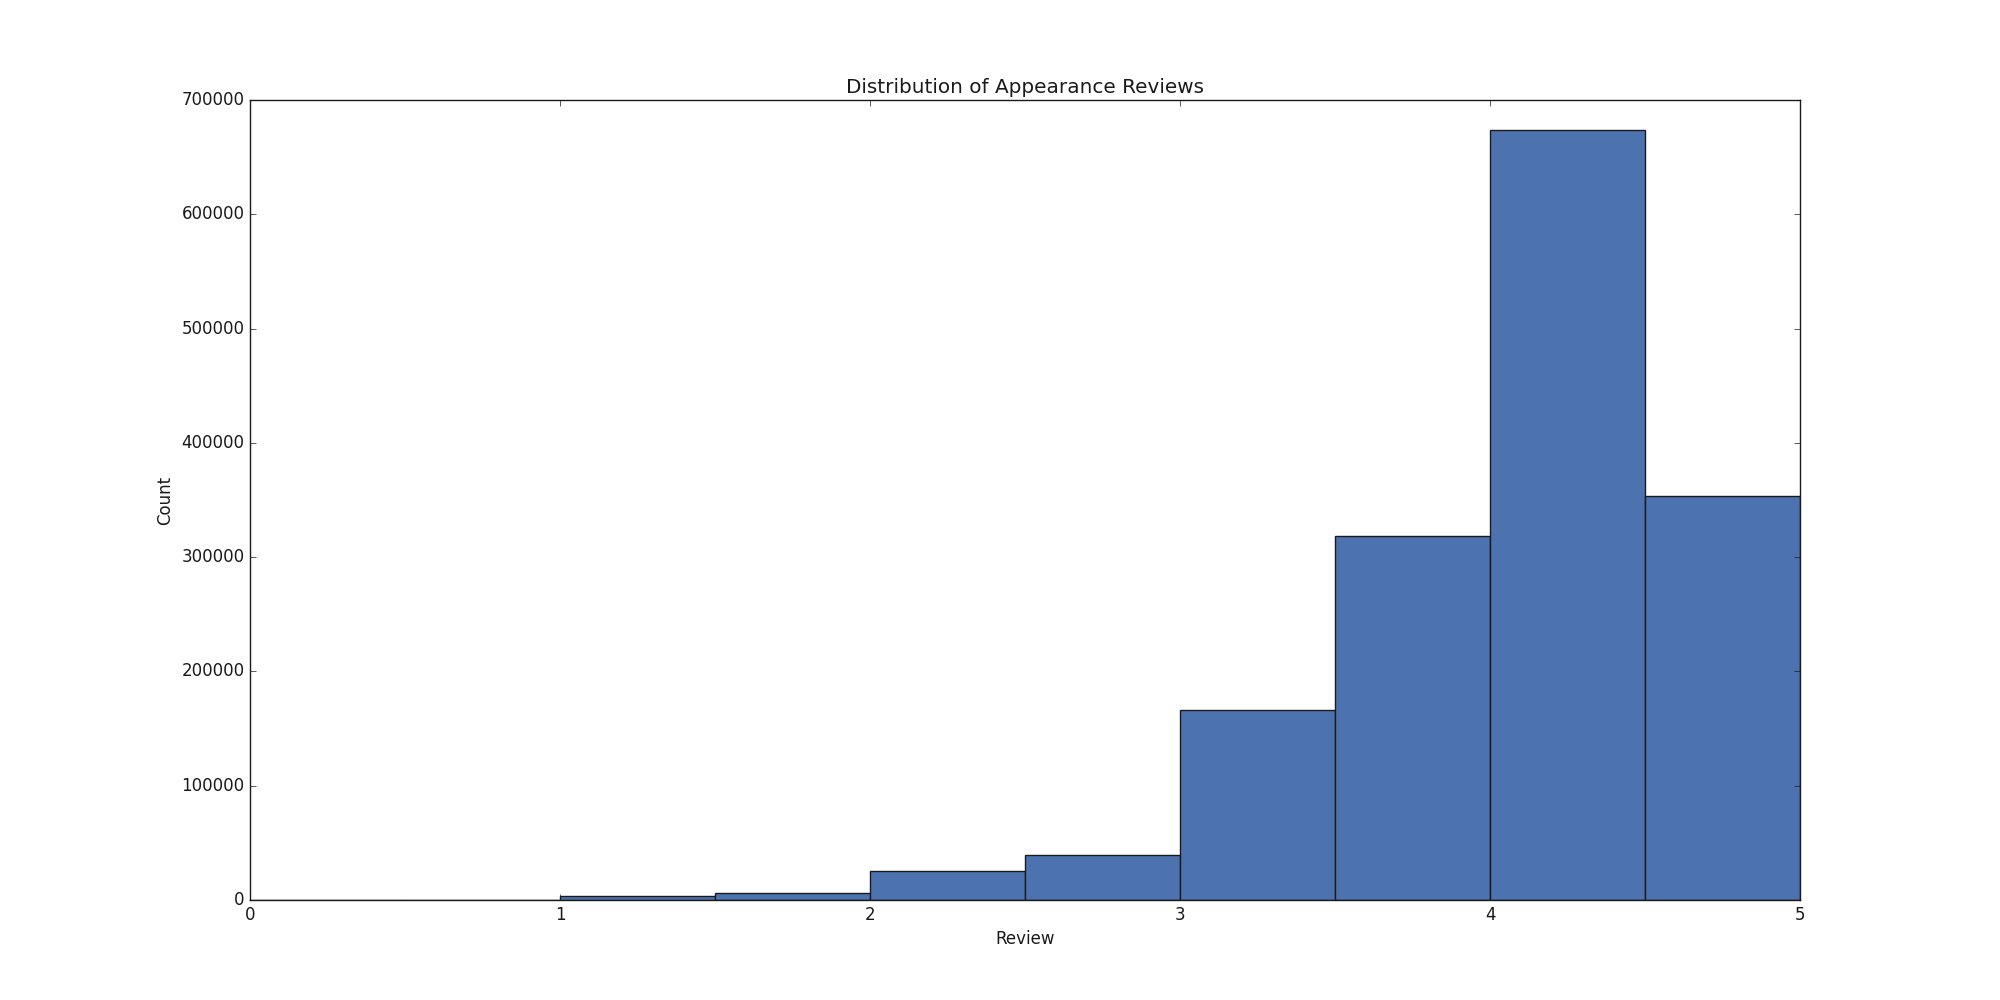

In [ ]:
%matplot plt

In [ ]:
# Create a plot for distribution of reviews for palate
plt.clf()
plt.figure(figsize=(20,10))
plt.style.use('classic')
plt.hist(beer_df.review_palate, bins=10)
plt.title('Distribution of Palate Reviews')
plt.xlabel('Review')
plt.ylabel('Count')
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

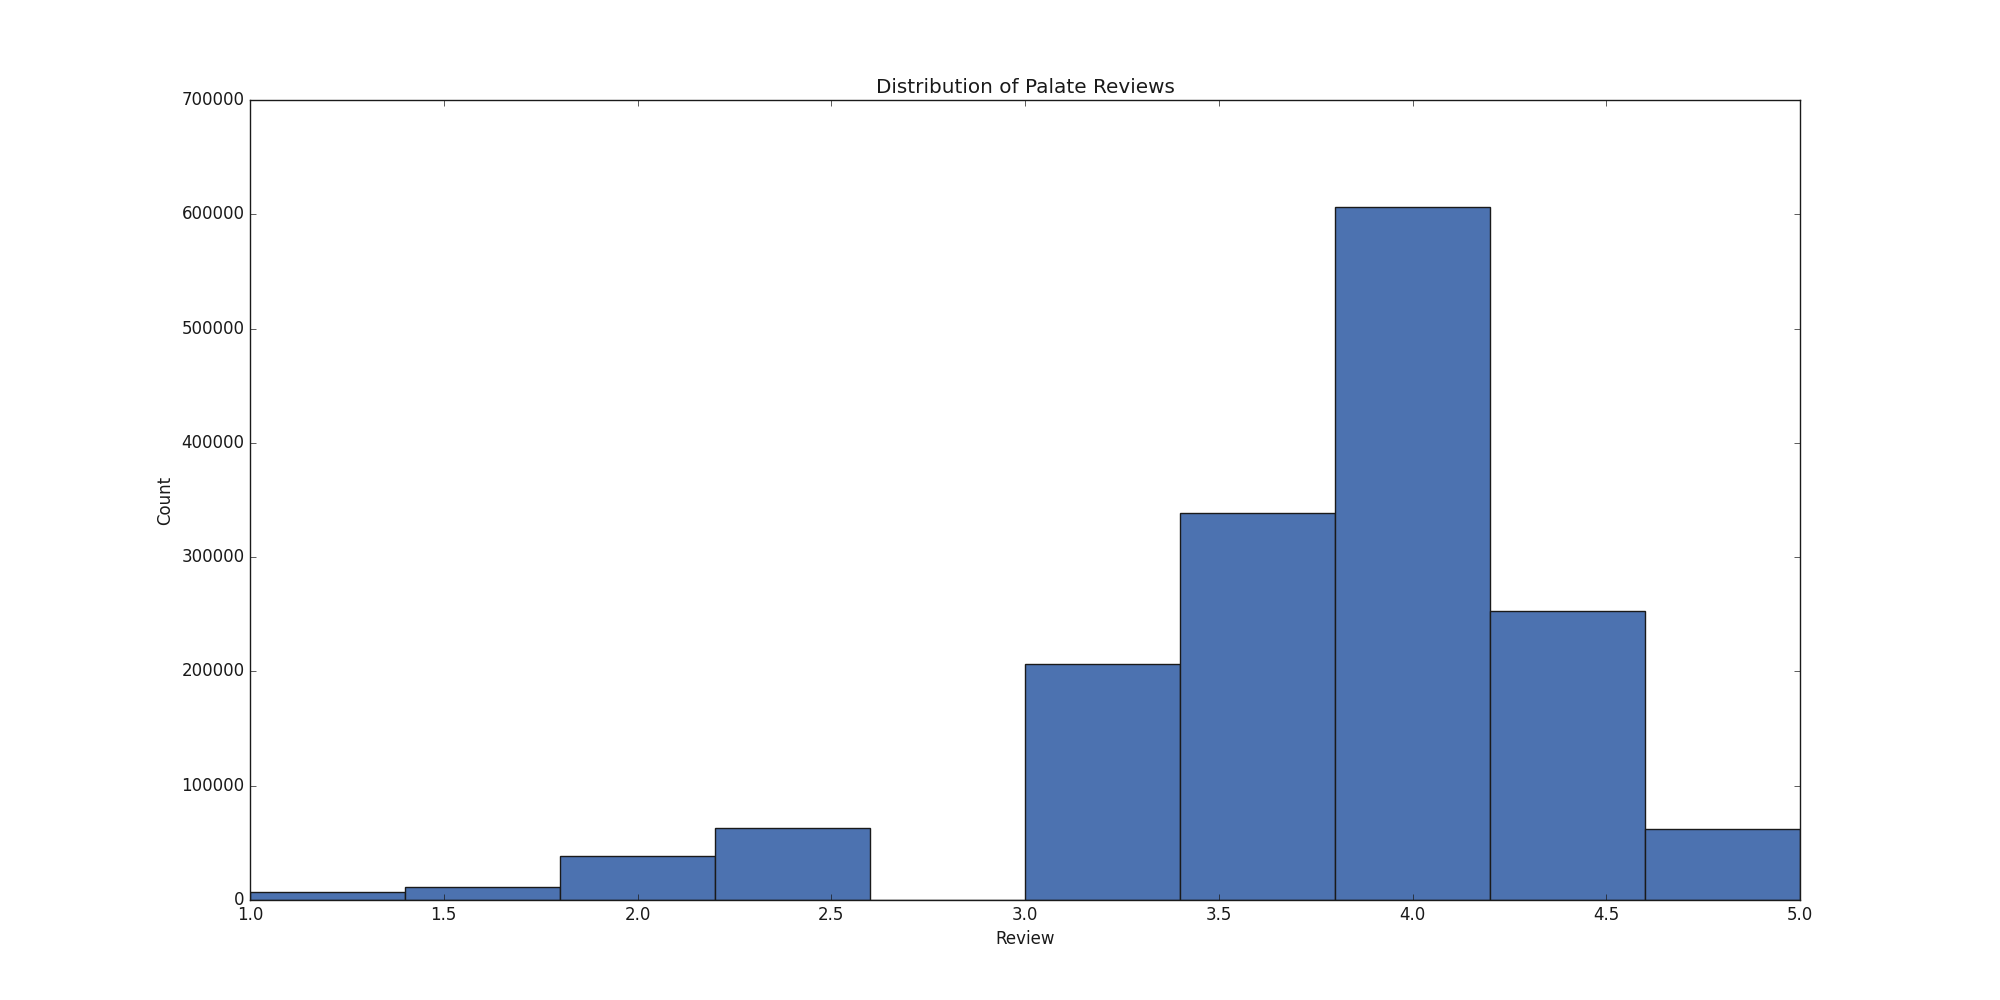

In [ ]:
%matplot plt

In [ ]:
# Create a plot for distribution of reviews for taste
plt.clf()
plt.figure(figsize=(20,10))
plt.style.use('classic')
plt.hist(beer_df.review_taste, bins=10)
plt.title('Distribution of Taste Reviews')
plt.xlabel('Review')
plt.ylabel('Count')
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

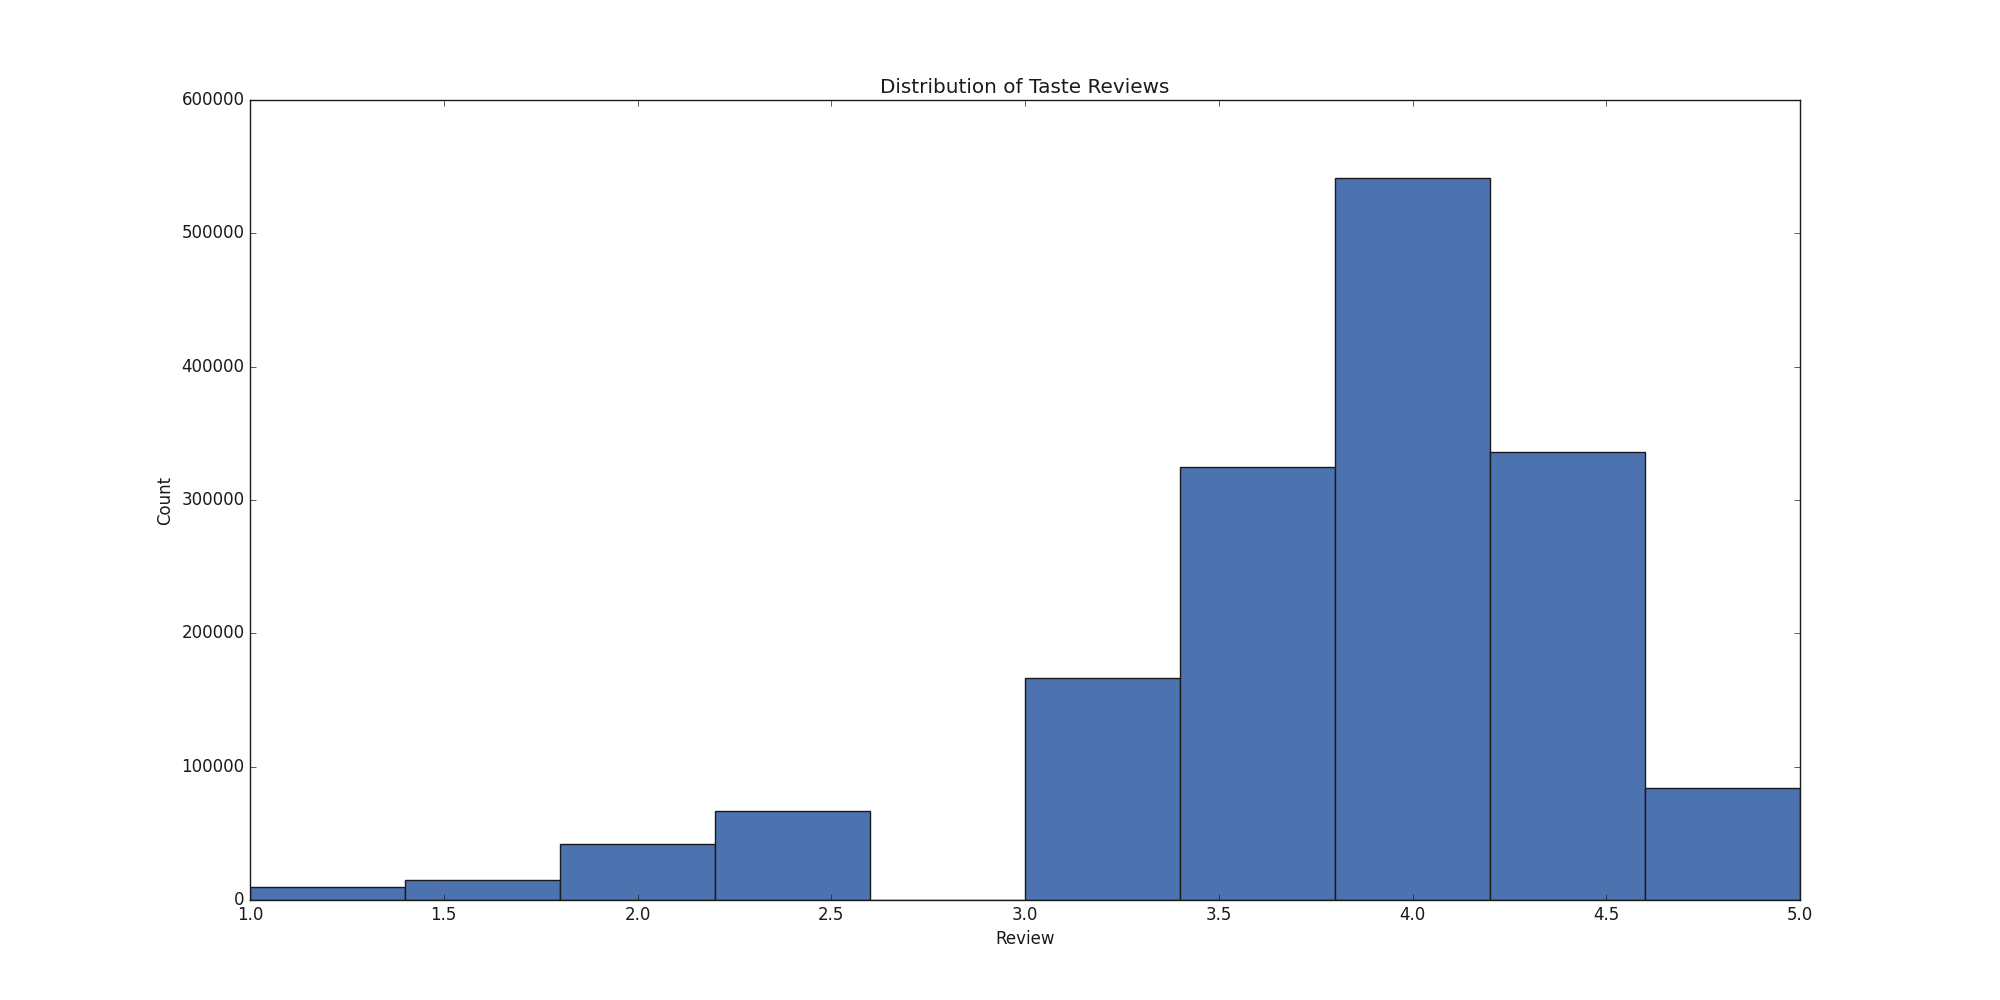

In [ ]:
%matplot plt

In [ ]:
# Finally, show distribution of ABV for the beers in the dataset
plt.clf()
plt.figure(figsize=(20,10))
plt.style.use('classic')
plt.hist(beer_df.beer_abv, bins=20)
plt.title('Distribution of ABV')
plt.xlabel('ABV')
plt.ylabel('Count')
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/usr/local/lib64/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib64/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

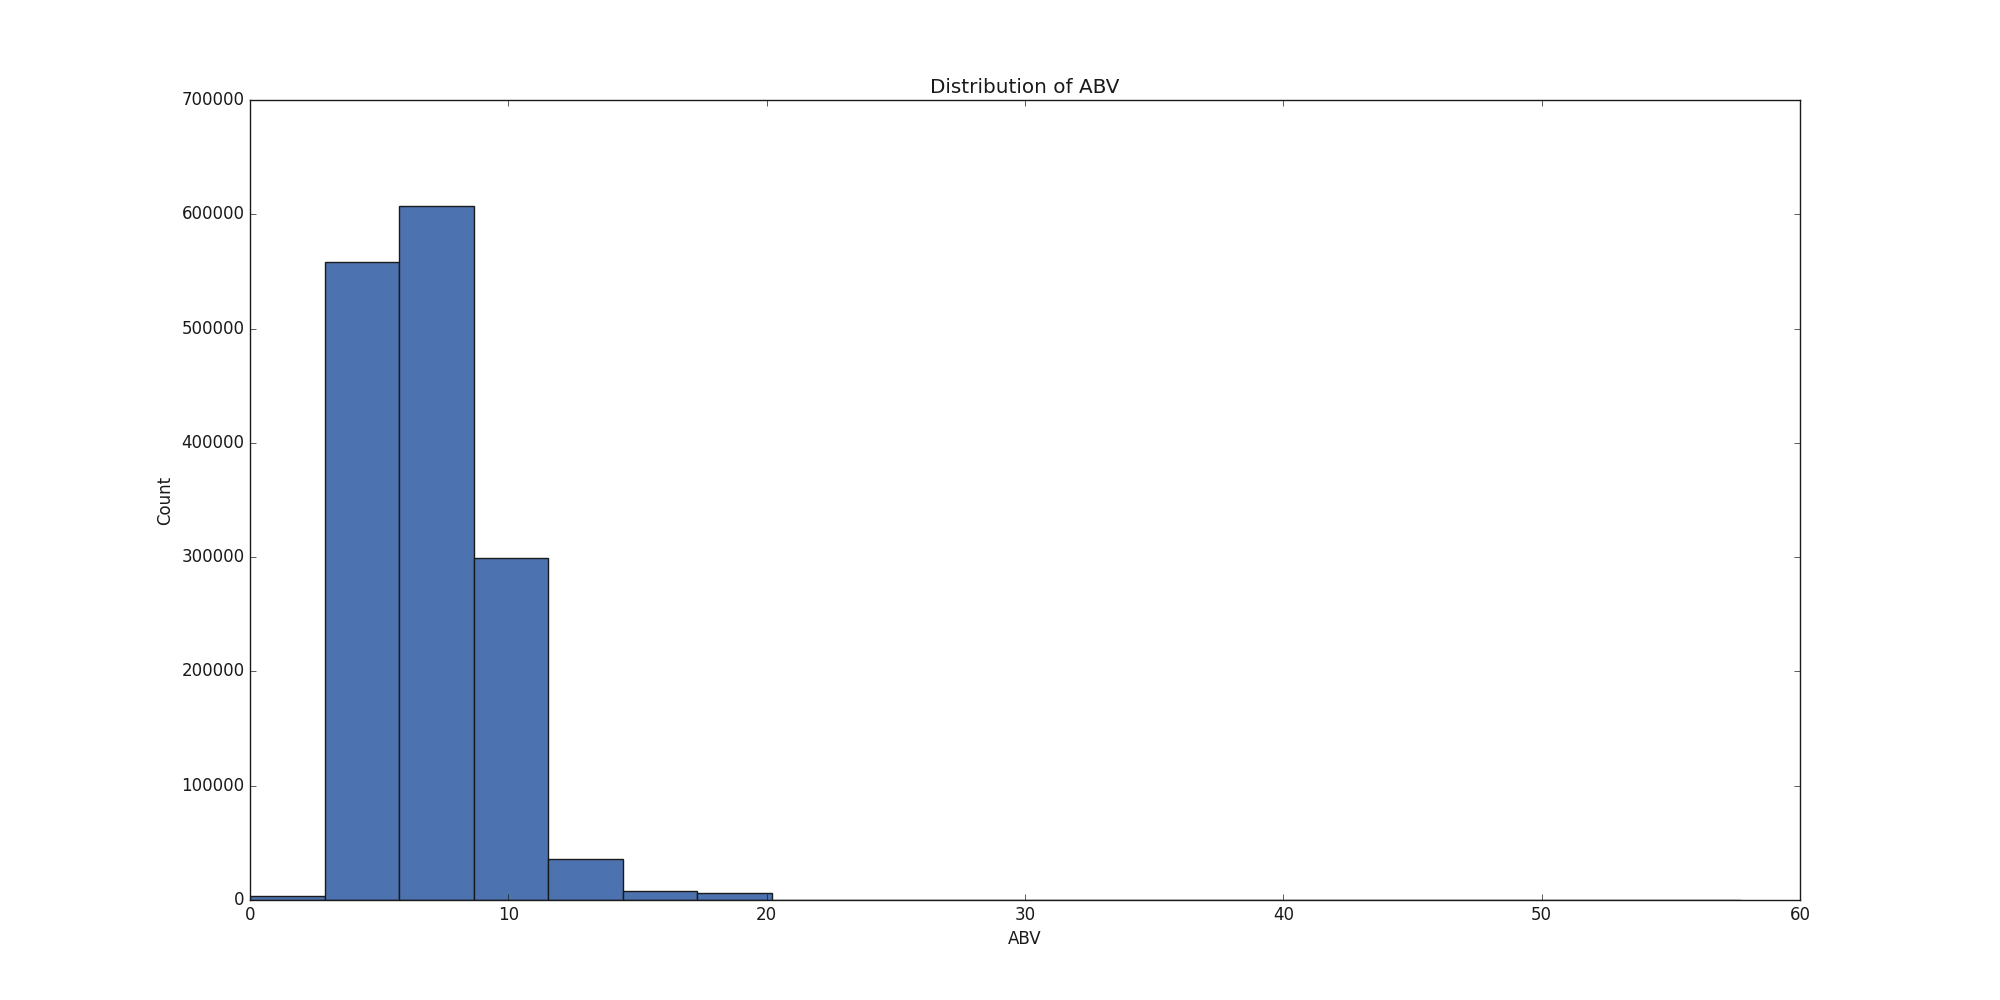

In [ ]:
%matplot plt

Correlations between different types of reviews

In [ ]:
beer_corr = beer_df[['review_aroma', 'review_appearance', 'review_overall', 'review_palate', 'review_taste']]
beer_corr.corr()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                   review_aroma  review_appearance  ...  review_palate  review_taste
review_aroma           1.000000           0.561008  ...       0.616937      0.716769
review_appearance      0.561008           1.000000  ...       0.566647      0.546980
review_overall         0.615986           0.501723  ...       0.701900      0.789798
review_palate          0.616937           0.566647  ...       1.000000      0.734122
review_taste           0.716769           0.546980  ...       0.734122      1.000000

[5 rows x 5 columns]

In [ ]:
# heatmap for correlations between different review types
plt.clf()
cm = np.corrcoef(beer_corr.values.T)
cols = ['review_aroma', 'review_appearance', 'review_overall', 'review_palate', 'review_taste']
sns.set(font_scale=0.8)
sns.heatmap(cm,                
                 cbar=True,       
                 annot=True,        
                 square=True,     
                 fmt='.2f',         
                 annot_kws={'size': 10},
                 yticklabels=cols,  
                 xticklabels=cols)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

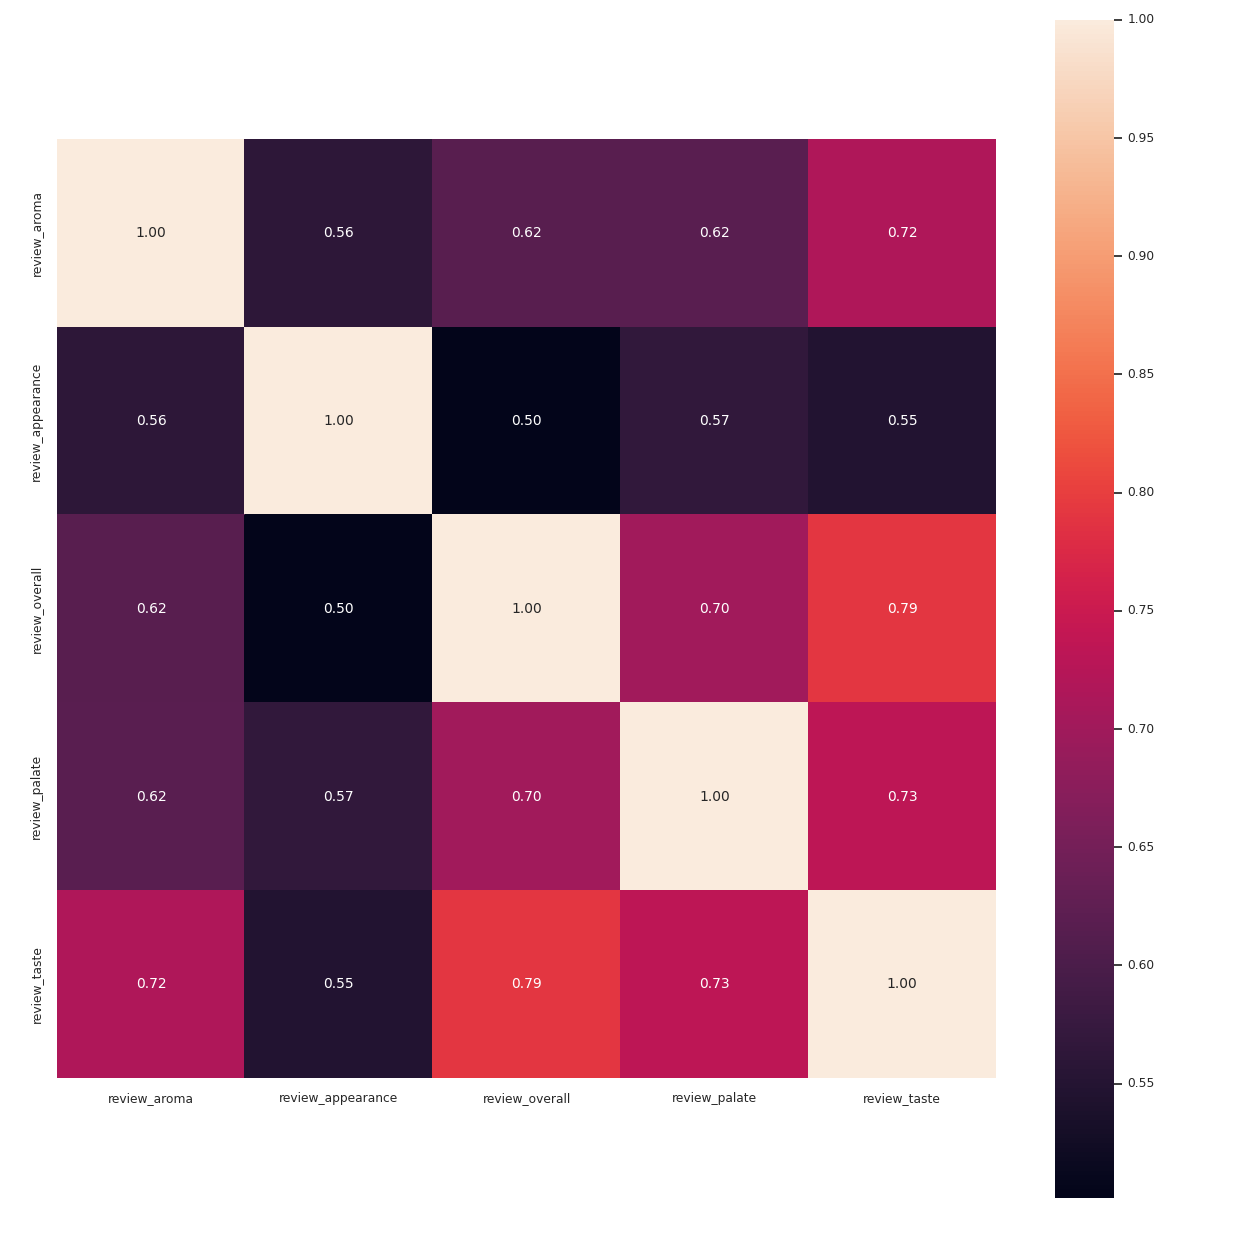

In [ ]:
%matplot plt

Recommendation System using ALS from Mllib

In [ ]:
# recommendation engine using ALS
# https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.recommendation.ALS
from pyspark.ml.recommendation import ALS

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# ALS requires that the userCol be an integer, but we currently have unique identifiers that are strings.
# solution: use string indexer from spark mllib to create a unique id for each user name
# https://spark.apache.org/docs/latest/ml-features.html#stringindexer 
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="review_profilename", outputCol="user_id")
# set setHandleInvalid to skip to avoid errors for nulls
beer = indexer.setHandleInvalid("skip").fit(beer).transform(beer)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# split our data into training and test
(training, test) = beer.randomSplit([0.8, 0.2])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Import the required functions
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

als = ALS(
    # the users are represented by the column review_profilename
         userCol="user_id", 
    # the items we are recommending are in the beer_name column
         itemCol="beer_beerid",
    # we will use the overall review to make the predictions
         ratingCol="review_overall", 
    # the preferences are explicit (i.e. a user explictly rated beer X as Y)
         implicitPrefs = False, 
    # drop rows with NA values
    coldStartStrategy="drop")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# define evaluator as RMSE
# we want to use RMSE to compare our predicted ratings for a user to their actual rating

evaluator = RegressionEvaluator(
           metricName="rmse", 
           labelCol="review_overall", 
           predictionCol="prediction")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# fit the model to the training data
model = als.fit(training)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# use our model to  make predictions for the test data
test_predictions = model.transform(test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# let's take a look at some of the predictions our model made
test_predictions.select(['review_profilename', 'review_overall', 'beer_name', 'prediction']).show(n=10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+--------------+--------------------+----------+
|review_profilename|review_overall|           beer_name|prediction|
+------------------+--------------+--------------------+----------+
|        jarmby1711|           3.5|     Pilsner Urquell| 3.5362632|
|            Buebie|           4.0|                Brrr|  3.714517|
|         beertunes|           3.5|Cherry Oak Doppel...| 3.3907247|
|         beertunes|           4.0|     Pitch Black IPA| 3.6501386|
|            Buebie|           3.0|                Okto| 3.3800929|
|         beertunes|           4.0|W'11 (KGB Imperia...| 3.4392614|
|         beertunes|           3.5| Nelson Imperial IPA|  3.595857|
|            Buebie|           4.0|Citra Summer Blon...| 3.6167002|
|        CortexBomb|           4.0|  Blanche De Chambly|  3.619169|
|        CortexBomb|           4.0|        Édition 2005| 3.6346753|
+------------------+--------------+--------------------+----------+
only showing top 10 rows

In [ ]:
# it appears that the predictions are not too far from the true rating.  We can calculate the RMSE for the test data
rmse = evaluator.evaluate(test_predictions)
print('Root-mean-square error = ' + str(rmse))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Root-mean-square error = 0.5488080353933126

The RMSE for this model is 0.55, meaning that on average, the difference between the actual rating and the prediction is 0.55.

In [ ]:
# now we can use the model to make recommendations for each user.  We can start by making 3 recommendations for each user
recommendations = model.recommendForAllUsers(numItems = 3)
recommendations.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|     12|[[51494, 5.044155...|
|     65|[[51494, 5.042790...|
|     76|[[32744, 5.021610...|
|     81|[[51494, 5.268062...|
|    122|[[51494, 5.107185...|
+-------+--------------------+
only showing top 5 rows

In [ ]:
# these ratings are not interpretable.  Let's convert it into an interpretable format
# https://towardsdatascience.com/build-recommendation-system-with-pyspark-using-alternating-least-squares-als-matrix-factorisation-ebe1ad2e7679
from pyspark.sql.functions import explode, col

recommendations = recommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('user_id', col("rec_exp.beer_beerid"), col("rec_exp.rating"))

recommendations.limit(10).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------+---------+
|user_id|beer_beerid|   rating|
+-------+-----------+---------+
|     12|      51494| 5.044155|
|     12|      32744|5.0154595|
|     12|      66841| 4.956703|
|     65|      51494|5.0427904|
|     65|      66841| 4.973891|
|     65|      32744| 4.957638|
|     76|      32744|5.0216107|
|     76|      51494|4.9888606|
|     76|      73376| 4.976244|
|     81|      51494|5.2680626|
+-------+-----------+---------+

In [ ]:
# register recommendations as a table
recommendations.registerTempTable("recommendations")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# regiester predictions as a table
test_predictions.registerTempTable("predictions")

In [ ]:
# try joining recommendations with predictions to get the user name, beer name, etc.
recommendations_expanded = sqlContext.sql("SELECT r.user_id, r.beer_beerid, r.rating, p.review_overall, p.beer_name, p.brewery_name FROM recommendations AS r JOIN predictions AS p on r.user_id = p.user_id")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
recommendations_expanded.registerTempTable('recommendations_expanded')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# let's compare the user's recommended beers to the beers they actually rated the highest

# beers recommended by the system:
user1 = sqlContext.sql("SELECT DISTINCT r.user_id, r.rating, b.brewery_name, b.beer_name FROM recommendations AS r JOIN beer AS b ON r.beer_beerid = b.beer_beerid WHERE r.user_id = 1 ")
user1.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+--------------------+--------------------+
|user_id|   rating|        brewery_name|           beer_name|
+-------+---------+--------------------+--------------------+
|      1|5.1374626|Kuhnhenn Brewing ...|Kuhnhenn Pumpkin ...|
|      1| 5.283623|Piece Brewery & P...| 8th Anniversary Ale|
|      1|5.2134614|Triumph Brewing C...|           Snakebite|
+-------+---------+--------------------+--------------------+

In [ ]:
# user1's actual favorite beers:
user1_favorites = sqlContext.sql("SELECT DISTINCT user_id, review_overall, brewery_name, beer_name FROM recommendations_expanded WHERE user_id = 1 ORDER BY review_overall DESC")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
user1_favorites.limit(5).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------+--------------------+--------------------+
|user_id|review_overall|        brewery_name|           beer_name|
+-------+--------------+--------------------+--------------------+
|      1|           5.0|Bell's Brewery, Inc.|     Two Hearted Ale|
|      1|           5.0|Ballast Point Bre...|Sculpin India Pal...|
|      1|           5.0| Brouwerij Het Anker|Gouden Carolus Tr...|
|      1|           5.0|Brouwerij St. Ber...|        Watou Tripel|
|      1|           5.0|Browar Okocim S.A...|       Okocim Porter|
+-------+--------------+--------------------+--------------------+

In [ ]:
# You can also recommend top users for different beers.  This could be useful for a marketing campaign
user_recommendations = model.recommendForAllItems(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
user_recommendations.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- beer_beerid: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- user_id: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)

In [ ]:
# view the recommended users for each beer:
user_recommendations = user_recommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('beer_beerid', col("rec_exp.user_id"), col("rec_exp.rating"))

user_recommendations.limit(10).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-------+---------+
|beer_beerid|user_id|   rating|
+-----------+-------+---------+
|          3|  32811|6.4502797|
|          3|  17463|5.7543173|
|          3|  23615|5.7270265|
|          3|  19200|5.7216086|
|          3|  31975| 5.656811|
|          3|  23446| 5.656811|
|          3|  25128| 5.580295|
|          3|  30897| 5.529418|
|          3|  22372|5.5293846|
|          3|  32421|5.5252585|
+-----------+-------+---------+